In [1]:
import pandas as pd
import os
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

In [16]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AdamW
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


class ChemBERTaWithFeatures(nn.Module):
    def __init__(self, chemberta_model_name, feature_dim):
        super(ChemBERTaWithFeatures, self).__init__()
        self.chemberta = AutoModel.from_pretrained(chemberta_model_name)
        self.dropout_bert = nn.Dropout(0.4)
        self.feature_batch_norm = nn.BatchNorm1d(feature_dim)
        self.feature_dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(self.chemberta.config.hidden_size + feature_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.activation = nn.SELU()

    def forward(self, input_ids, attention_mask, features):
        chemberta_output = self.chemberta(input_ids, attention_mask=attention_mask)
        cls_output = self.dropout_bert(chemberta_output.last_hidden_state[:, 0, :])
        normalized_features = self.feature_dropout(self.feature_batch_norm(features))
        concatenated = torch.cat((cls_output, normalized_features), dim=1)
        hidden1 = self.activation(self.fc1(concatenated))
        hidden2 = self.activation(self.fc2(hidden1))
        logits = self.fc3(hidden2)
        probabilities = torch.sigmoid(logits)
        return probabilities

# Dataset class
class MoleculeDataset(Dataset):
    def __init__(self, encodings, features, labels):
        self.encodings = encodings
        self.features = features
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['features'] = torch.tensor(self.features[idx], dtype=torch.float32)
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32)
        return item

    def __len__(self):
        return len(self.labels)



In [3]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score
def compute_metrics(preds, labels):
    preds = preds.round()  # Convert probabilities to binary predictions
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, zero_division=0)  # Avoid division by zero
    return accuracy, precision

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train Loss: 0.6908453106880188, Train Accuracy: 0.5517241379310345
Epoch 1: Val Loss: 0.6841498017311096, Val Accuracy: 0.44
Epoch 2: Train Loss: 0.6799485087394714, Train Accuracy: 0.5886699507389163
Epoch 2: Val Loss: 0.6795376241207123, Val Accuracy: 0.54
Epoch 3: Train Loss: 0.6742781377755679, Train Accuracy: 0.625615763546798
Epoch 3: Val Loss: 0.6749072074890137, Val Accuracy: 0.58
Epoch 4: Train Loss: 0.6678197452655206, Train Accuracy: 0.6330049261083743
Epoch 4: Val Loss: 0.67110675573349, Val Accuracy: 0.54
Epoch 5: Train Loss: 0.6504631844850687, Train Accuracy: 0.6896551724137931
Epoch 5: Val Loss: 0.6654134392738342, Val Accuracy: 0.58
Epoch 6: Train Loss: 0.6474734132106488, Train Accuracy: 0.6921182266009852
Epoch 6: Val Loss: 0.6592298299074173, Val Accuracy: 0.56
Epoch 7: Train Loss: 0.6367758833445035, Train Accuracy: 0.6773399014778325
Epoch 7: Val Loss: 0.6502734124660492, Val Accuracy: 0.56
Epoch 8: Train Loss: 0.6257310899404379, Train Accuracy: 0.689655

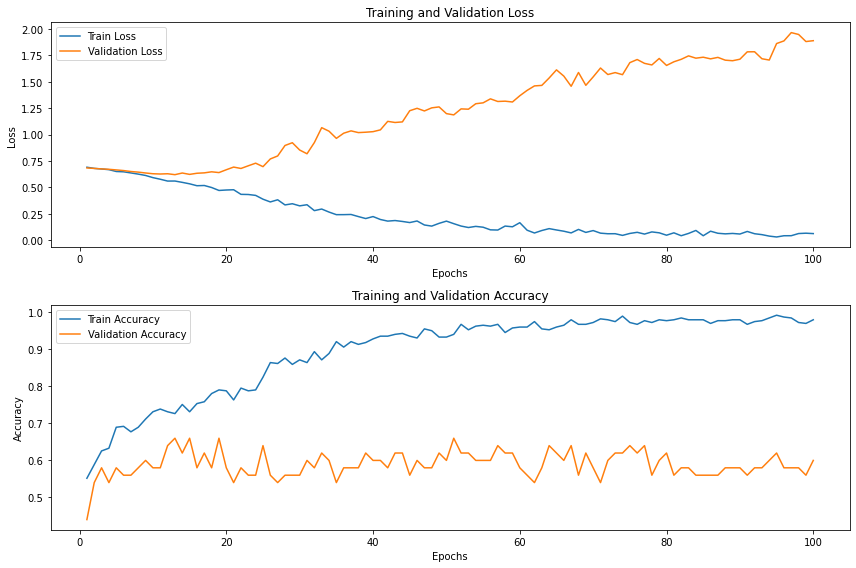

In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
import torch
from torch import nn
from torch.optim import AdamW
import matplotlib.pyplot as plt

# Data loading and preparation
features_columns = ['Molecular Weight', 'LogP', 'Number of Atoms',
       'Number of Bonds', 'Number of Rings', 'Rotatable Bonds Count',
       'Hydrogen Bond Donors', 'Hydrogen Bond Acceptors',
       'Number of Stereocenters', 'Topological Polar Surface Area (TPSA)']

train_data = pd.read_csv('/home/parsa/smiles_classification/training_w_features.csv').sample(frac=1)
val_data = pd.read_csv('/home/parsa/smiles_classification/validation_w_features.csv').sample(frac=1)

X_train, X_val = train_data[features_columns].values, val_data[features_columns].values
y_train, y_val = train_data['Results'].values, val_data['RESULT'].values

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

tokenizer = AutoTokenizer.from_pretrained('DeepChem/ChemBERTa-77M-MLM')
train_encodings = tokenizer(list(train_data['SMILES']), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_data['SMILES']), truncation=True, padding=True, max_length=512)

train_dataset = MoleculeDataset(train_encodings, X_train_scaled, y_train)
val_dataset = MoleculeDataset(val_encodings, X_val_scaled, y_val)

# Set up DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Define the device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Initialize model
model = ChemBERTaWithFeatures('DeepChem/ChemBERTa-77M-MLM', feature_dim=10).to(device)
loss_function = nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)

num_epochs = 100

# Placeholder for tracking metrics across epochs
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        features = batch['features'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, features)
        loss = loss_function(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        all_preds.extend(outputs.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    train_accuracy, _ = compute_metrics(torch.tensor(all_preds), torch.tensor(all_labels))
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            features = batch['features'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask, features).squeeze(1)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            all_preds.extend(outputs.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

    val_accuracy, _ = compute_metrics(torch.tensor(all_preds), torch.tensor(all_labels))
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Loss: {total_loss / len(train_loader)}, Train Accuracy: {train_accuracy}")
    print(f"Epoch {epoch+1}: Val Loss: {val_loss / len(val_loader)}, Val Accuracy: {val_accuracy}")

# Plot training and validation metrics
plt.figure(figsize=(12, 8))

# Training and validation loss
plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Training and validation accuracy
plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Hyperparameter Tuning: 100%|██████████| 210/210 [07:27<00:00,  2.13s/it]


Model checkpoint saved as 'best_model_checkpoint.pth'
Best parameters: {'dropout': 0.6, 'learning_rate': 1e-05, 'hidden_units': 256, 'weight_decay': 1e-05} with validation loss: 2.663298189640045 and validation accuracy: 0.66


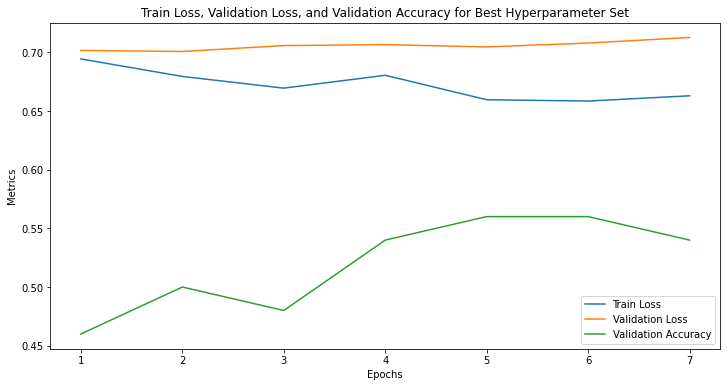

In [44]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
import torch
from torch import nn
from torch.optim import AdamW
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

from transformers import logging
logging.set_verbosity_error()

# Define the device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Hyperparameter tuning setup
param_grid = {
    'dropout': [0.3, 0.4, 0.5, 0.6, 0.7],
    'learning_rate': [1e-4, 3e-5, 1e-5],
    'hidden_units': [128, 256, 512, 1024, 2048, 2048 * 2, 2048 * 4],
    'weight_decay': [1e-4, 1e-5]
}

total_models = (
    len(param_grid['dropout']) *
    len(param_grid['learning_rate']) *
    len(param_grid['hidden_units']) *
    len(param_grid['weight_decay'])
)

progress_bar = tqdm(total=total_models, desc="Hyperparameter Tuning")

best_model = None
best_val_loss = float('inf')
best_val_accuracy = 0.0
all_results = []

def compute_metrics(preds, labels):
    preds = (preds > 0.5).float()
    accuracy = (preds == labels).sum().item() / len(labels)
    return accuracy

def train_and_evaluate(params):
    class ChemBERTaWithFeatures(nn.Module):
        def __init__(self, chemberta_model_name, feature_dim):
            super(ChemBERTaWithFeatures, self).__init__()
            self.chemberta = AutoModel.from_pretrained(chemberta_model_name)
            self.dropout_bert = nn.Dropout(params['dropout'])
            self.feature_batch_norm = nn.BatchNorm1d(feature_dim)
            self.feature_dropout = nn.Dropout(params['dropout'])
            self.fc1 = nn.Linear(self.chemberta.config.hidden_size + feature_dim, params['hidden_units'])
            self.fc2 = nn.Linear(params['hidden_units'], 1)
            self.activation = nn.SELU()

        def forward(self, input_ids, attention_mask, features):
            chemberta_output = self.chemberta(input_ids, attention_mask=attention_mask)
            cls_output = self.dropout_bert(chemberta_output.last_hidden_state[:, 0, :])
            normalized_features = self.feature_dropout(self.feature_batch_norm(features))
            concatenated = torch.cat((cls_output, normalized_features), dim=1)
            hidden = self.activation(self.fc1(concatenated))
            logits = self.fc2(hidden)
            probabilities = torch.sigmoid(logits)
            return probabilities

    model = ChemBERTaWithFeatures('DeepChem/ChemBERTa-77M-MLM', feature_dim=10).to(device)
    optimizer = AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    loss_function = nn.BCELoss()

    early_stopping_patience = 5
    best_epoch_val_loss = float('inf')
    best_epoch_val_accuracy = 0.0
    early_stopping_counter = 0

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(100):
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            features = batch['features'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, features)
            loss = loss_function(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))

        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                features = batch['features'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask, features).squeeze(1)
                loss = loss_function(outputs, labels)
                val_loss += loss.item()
                all_preds.extend(outputs.detach().cpu())
                all_labels.extend(labels.detach().cpu())

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = compute_metrics(torch.tensor(all_preds), torch.tensor(all_labels))
        val_accuracies.append(val_accuracy)

        if val_loss < best_epoch_val_loss:
            best_epoch_val_loss = val_loss
            best_epoch_val_accuracy = val_accuracy
            best_model_state = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= early_stopping_patience:
            break

    model.load_state_dict(best_model_state)
    return best_epoch_val_loss, best_epoch_val_accuracy, train_losses, val_losses, val_accuracies

# Hyperparameter tuning loop
for dropout in tqdm(param_grid['dropout']):
    for learning_rate in param_grid['learning_rate']:
        for hidden_units in param_grid['hidden_units']:
            for weight_decay in param_grid['weight_decay']:
                params = {
                    'dropout': dropout,
                    'learning_rate': learning_rate,
                    'hidden_units': hidden_units,
                    'weight_decay': weight_decay
                }
                # print(f"Training with params: {params}")
                val_loss, val_accuracy, train_losses, val_losses, val_accuracies = train_and_evaluate(params)
                all_results.append((params, val_loss, val_accuracy))

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_val_accuracy = val_accuracy
                    best_model = copy.deepcopy(model)

                progress_bar.update(1)

progress_bar.close()
# Save the best model
torch.save(best_model.state_dict(), './best_chembert_finetune_model_checkpoint.pth')
print("Model checkpoint saved as 'best_model_checkpoint.pth'")
# Plot results
best_run = min(all_results, key=lambda x: x[1])
print(f"Best parameters: {best_run[0]} with validation loss: {best_run[1]} and validation accuracy: {best_run[2]}")

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Train Loss, Validation Loss, and Validation Accuracy for Best Hyperparameter Set')
plt.legend()
plt.show()

